# Introduction to image processing

In this tutorial, we will go over the basics of image I/O, display and pre-processing with a view to developing **deep learning** algorithms for medical imaging applications.

## What is an image?
An image is nothing more than a uniform grid of numbers that occupy two (or more!) dimensions. The terms 'array', 'matrix', and 'tensor' can be used interchangeably to describe images.

![title](http://pippin.gimp.org/image_processing/images/sample_grid_a_square.png)


## Loading images using Python
For 2D images, we are spoiled for choice but let's use Pillow for now:

In [84]:
from PIL import Image

img = Image.open('retina.tif')
print(img)

<PIL.TiffImagePlugin.TiffImageFile image mode=RGB size=565x584 at 0x2BCEC18CE48>


Note that the image has been loaded as a PIL object. We want to grab the raw image pixels, so let's use numpy and check the image dimensions too:

In [85]:
import numpy as np  # common abbreviation
img_arr = np.asarray(img)
print(img_arr.shape)

(584, 565, 3)


Three channels - perhaps it's a color image? Let's look at the image properly using matplotlib:

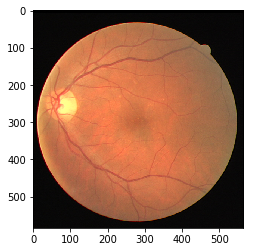

In [86]:
import matplotlib as mpl
import matplotlib.pyplot as plt  # another common abbreviation
%matplotlib inline

plt.imshow(img_arr)

That looks suspicously like a retina. The three channels correspond to the <font color='red'>red</font>, <font color='green'>green</font> and <font color='blue'>blue</font> components of the image. Let's (inefficiently) stack the color channels side by side using numpy, and look at them. 

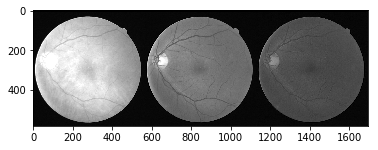

In [87]:
stacked = []  # empty list

for channel in range(0, img_arr.shape[2]):  # loop through channels
    
    img_slice = img_arr[:, :, channel]  # all rows, all columns, one channel
    stacked.append(img_slice)  # append it to a list
    
stacked_arr = np.hstack(stacked)  # stack them horizontally
plt.imshow(stacked_arr, cmap="gray")  # show in grayscale

Lots of red, some green, and not much blue. Incidentally, it's quite common to use only the <font color='green'>**green channel**</font> for vessel/optic segmentation. **Why?**

## Image processing - thresholding & morphology
Let's play with the green channel for a bit. Can we use image processing techniques estimate the location of the optic disk? 

We can examine the range of intensity values using a histogram:

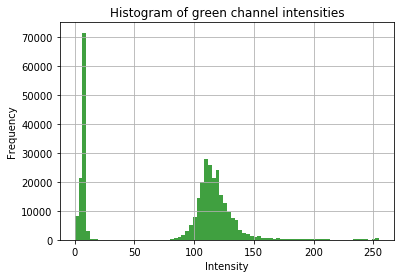

In [88]:
green = stacked[1]

# The .ravel() function collapses the image into a 1D vector
n, bins, patches = plt.hist(green.ravel(), bins='auto', facecolor='g', alpha=0.75)

# Axis labels!
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of green channel intensities')
plt.grid(True)
plt.show()

It seems there is a small cluster of bright pixels on the far right (> 200). Let's create a binary image, using 200 as our threshold.

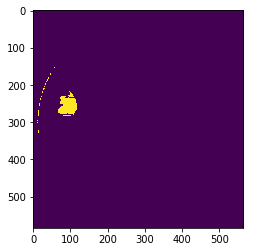

In [89]:
thresh = (green > 200).astype(np.uint8)  # convert from boolean to numeric
plt.imshow(thresh)

Not bad! Let's see if we can't clean it up a bit. Morphological *erosion* applies a 'structuring element' of a given size to chip away at (and completely remove) objects. The opposite process - *dilation* - grows those objects (and can fuse them).


![title](https://www.researchgate.net/profile/Victor_Mateevitsi/publication/274454691/figure/fig2/AS:294830786793473@1447304545623/Dilation-and-erosion-A-series-of-dilation-operations-cause-the-shadow-to-merge-with-the.png)

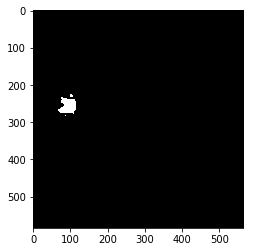

In [73]:
from skimage.morphology import disk
from skimage.morphology import binary_erosion, binary_dilation

eroded = binary_erosion(thresh, disk(radius=2))
plt.imshow(eroded, cmap="gray")

That worked quite well, but we lost a bit of our optic disk in the process. We can restore it using dilation. Erosion followed by dilation is called *opening*, wheras dilation followed by erosion is called *closing*. **Why?**

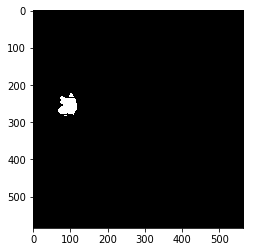

In [74]:
opened = binary_dilation(eroded, disk(radius=2))
plt.imshow(opened, cmap="gray")

It's not perfect, but can we use it to at least estimate the center of the optic disk?

We can compute the "center of mass" or "centroid" by finding the coordinates of all the white pixels and taking the average. Fortunately, numpy makes this very easy:

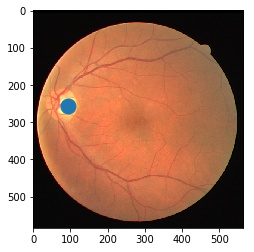

In [75]:
od_pixels = np.argwhere(opened)
centroid = np.mean(od_pixels, axis=0) # we are averaging over columns

plt.imshow(img_arr)
plt.plot(centroid[1], centroid[0], 'o', markersize=15) # why do we need to reverse the order?

Not bad for a first attempt! For a larger project, we might wish to save our intermediate steps.

## Saving images
We know how to load and manipulate images as numpy arrays. How can we save them? We can use Pillow again:

In [78]:
opened_img = Image.fromarray(opened)
opened_img.save('opened.png')

Something weird is going on... that image looks empty! The reason is that our image was saved as an **8-bit image**.  This means the image values range from $0 - 2^8$, or $0 - 255$. Our 'opened' image ranged from $0 - 14, which is pretty dark!

In [80]:
print(np.max(opened.astype(np.uint8)))

1


Let's fix it by multiplying the image pixels by 255.

In [83]:
opened_img = Image.fromarray(opened.astype(np.uint8) * 255)
opened_img.save('opened.png')